In [1]:
import pandas as pd 
import numpy as np

In [2]:
df =pd.read_csv('D:\Ori\数据处理\充值分析\充值流水订单下载报表.csv')

In [3]:
df.head()

,UID,订单号,注册时间,流水号,充值IP,充值时间,VIP类型,充值金额,充值方式,充值来源,状态
0,3487228,202304261401423014,2022-05-24 15:47:40,4200001862202304262628710810,153.101.140.200,2023-04-26 14:01:48,模板个人VIP 3个月,59.0,H5微信内官方,H5_Renew,正常
1,120845,202304261400087804,2021-02-22 10:17:24,288570032933202304261592683544,116.54.33.166,2023-04-26 14:01:19,模板个人VIP 3个月,59.0,微信-威富通,编辑页充值,正常
2,4718554,2023042613032952426,2023-04-26 12:47:55,2023042622001405841455159966,112.3.250.100,2023-04-26 13:03:39,线上用途SVIP,269.0,支付宝官方,编辑页充值,正常
3,4718554,2023042612595489170,2023-04-26 12:47:55,2023042622001405841452256116,112.3.250.100,2023-04-26 13:00:08,模板个人VIP 1个月,39.0,支付宝官方,编辑页充值,正常
4,906854,202304261141285682,2021-05-06 10:07:27,288570032933202304267522652984,121.204.36.116,2023-04-26 11:42:20,线上用途SVIP,249.0,微信-威富通,编辑页充值,正常


# 数据清洗

## 删除不需要的

In [4]:
# 删除不需要的列
df = df.drop(['订单号', '流水号', '充值IP', '状态'], axis=1)

In [5]:
# 筛选时期
df = df[(df['充值时间'] >= '2022-01-01 00:00:00') & (df['充值时间'] <= '2023-04-25 23:59:59')]

In [6]:
# 充值金额清洗，有几笔大额订单容易污染整个数据
df = df[(df['充值金额'] >= 10) & (df['充值金额'] <= 3000)]

In [ ]:
# 删除含有缺失值的指定行
df = df.dropna(subset=['注册时间', 'VIP类型', '充值时间'],axis=0)

In [39]:
df.head()

,UID,注册时间,充值时间,VIP类型,充值金额,充值方式,充值来源,时间差,时期内充值次数,时间桶
25,4691419,2023-04-11 22:56:37,2023-04-25 23:01:39,模板个人VIP 3个月,59.0,微信-威富通,编辑页充值,14,1.0,30日内
26,2464983,2021-11-20 13:58:11,2023-04-25 21:42:48,线上用途SVIP,269.0,微信-威富通,编辑页充值,521,3.0,超过365日
27,855419,2021-04-29 10:48:56,2023-04-25 21:36:46,模板个人VIP 1个月,39.0,微信-威富通,编辑页充值,726,2.0,超过365日
28,4717699,2023-04-25 20:03:17,2023-04-25 20:45:17,模板个人VIP 1个月,39.0,微信-威富通,编辑页充值,0,1.0,当日
29,4717738,2023-04-25 20:26:17,2023-04-25 20:32:31,模板个人VIP 1个月,39.0,微信-威富通,LeftTool,0,1.0,当日


## 查看数据

In [43]:
# 查看数据形状
df.shape

(30470, 10)

In [8]:
df.info()    # 看缺失值，和看所有列

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30512 entries, 25 to 30570
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UID     30512 non-null  int64  
 1   注册时间    30482 non-null  object 
 2   充值时间    30512 non-null  object 
 3   VIP类型   30512 non-null  object 
 4   充值金额    30512 non-null  float64
 5   充值方式    30454 non-null  object 
 6   充值来源    30512 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.9+ MB


## 数据转换

In [9]:
# 时间转化
df['注册时间'] = pd.to_datetime(df['注册时间'])
df['充值时间'] = pd.to_datetime(df['充值时间'])

In [11]:
# 计算时间差，并将结果转换为整数类型
df['时间差'] = ((df['充值时间'] - df['注册时间']) / np.timedelta64(1, 'D')).astype(int)

In [12]:
# 删除异常数据，时间差为负值或者超过2000的不符合逻辑
df = df[df.时间差.between(0,2000)]

In [13]:
# 这个报错可以无视，运行这个前需要先确定充值时间，不然排序有问题
df['时期内充值次数'] = df.groupby('UID')['充值时间'].rank(method='dense', ascending=True)

## 降维

In [24]:
# 定义降维函数
def 降维(x):
    if x == 0:
        return '当日'
    elif x >= 1 and x <= 7:
        return '7日内'
    elif x >= 8 and x <= 30:
        return '30日内'
    elif x >= 31 and x <= 90:
        return '90日内'
    elif x >= 91 and x <= 365:
        return '365日内'
    else:
        return '超过365日'

In [25]:
# 将时间差转换为文本型函数
df['时间桶'] = df['时间差'].apply(降维)

In [32]:
df.head()

,UID,注册时间,充值时间,VIP类型,充值金额,充值方式,充值来源,时间差,时期内充值次数,时间桶
25,4691419,2023-04-11 22:56:37,2023-04-25 23:01:39,模板个人VIP 3个月,59.0,微信-威富通,编辑页充值,14,1.0,30日内
26,2464983,2021-11-20 13:58:11,2023-04-25 21:42:48,线上用途SVIP,269.0,微信-威富通,编辑页充值,521,3.0,超过365日
27,855419,2021-04-29 10:48:56,2023-04-25 21:36:46,模板个人VIP 1个月,39.0,微信-威富通,编辑页充值,726,2.0,超过365日
28,4717699,2023-04-25 20:03:17,2023-04-25 20:45:17,模板个人VIP 1个月,39.0,微信-威富通,编辑页充值,0,1.0,当日
29,4717738,2023-04-25 20:26:17,2023-04-25 20:32:31,模板个人VIP 1个月,39.0,微信-威富通,LeftTool,0,1.0,当日


# 数据探索

In [33]:
df.describe()    # 描述性统计

,UID,充值金额,时间差,时期内充值次数
count,3.047000e+04,30470.00000,30470.000000,30470.000000
mean,2.782965e+06,127.17725,169.191631,1.394322
std,1.388833e+06,115.61278,216.675870,0.986788
min,1.400000e+02,10.00000,0.000000,1.000000
25%,1.844499e+06,39.00000,0.000000,1.000000
50%,3.100579e+06,69.00000,32.000000,1.000000
75%,3.874202e+06,199.00000,331.000000,1.000000
max,4.717738e+06,2799.00000,914.000000,21.000000


In [34]:
# 看单独一列内部结构
df['时间桶'].value_counts()

当日        12415
365日内      6819
超过365日     6605
90日内       1925
7日内        1365
30日内       1341
Name: 时间桶, dtype: int64

## 数据分布

In [35]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['Simhei']    # 需要中文时候加

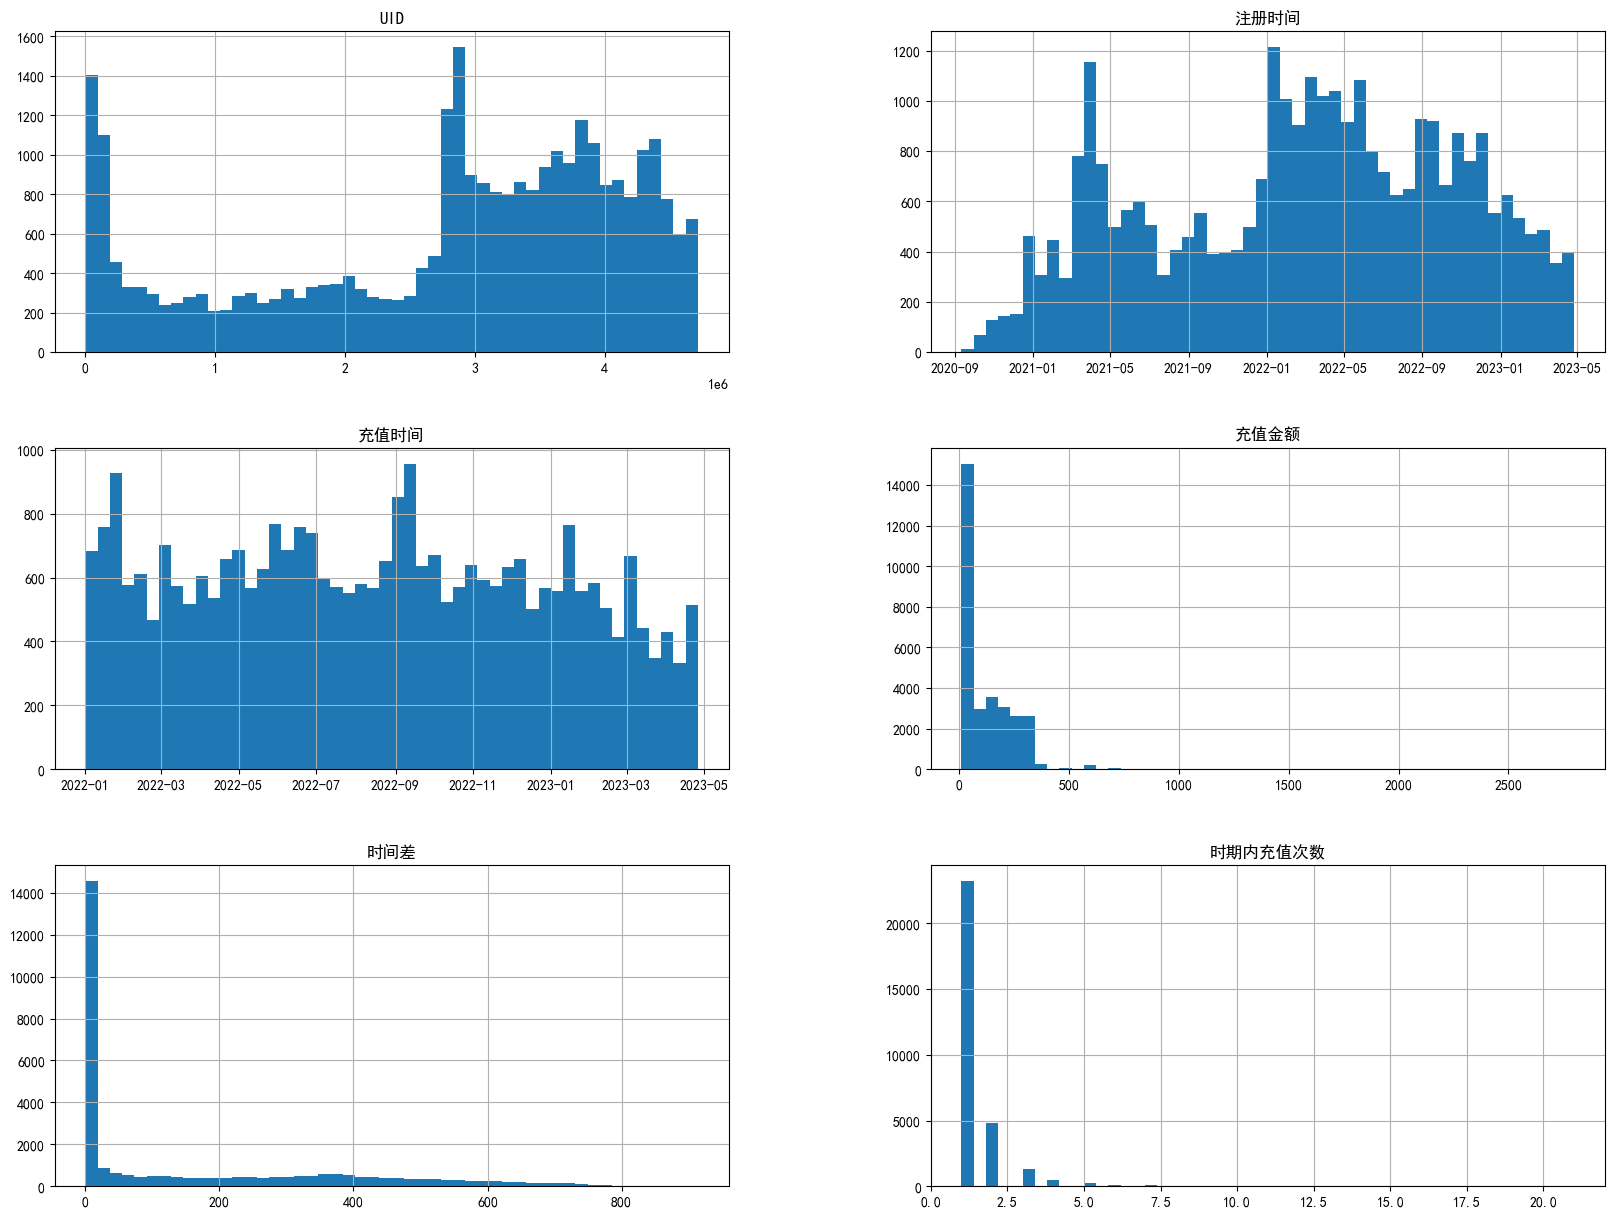

In [36]:
df.hist(bins=50    # 分箱个数
             ,figsize=(20,15)    # 可视化大小
             #,range=(0,100)    # 设置上限和下限
             #,cumulative=True    # 是否计算累计
             #,orientation='vertical'    # 水平和垂直
             #,alpha=0.8    # 透明度
             #,histtype='step'    # 柱子颜色填充
             #,edgecolor='#FFD700'    # 描边颜色
             #,color='red'    # 整体颜色
            )    # hist是直方图，看看数据整体分布
plt.show()

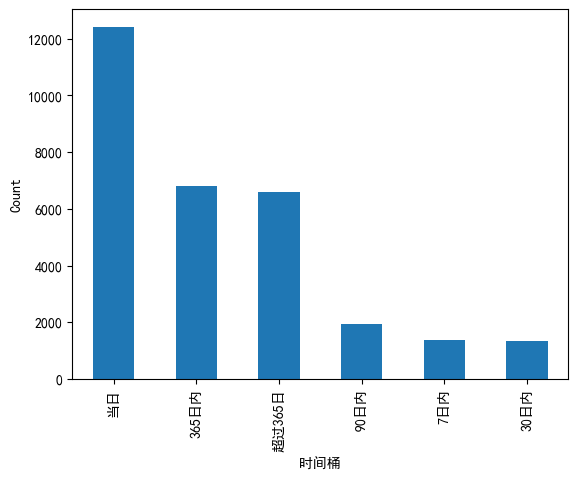

In [37]:
# 统计不同字符串类型的出现次数
counts = df['时间桶'].value_counts()

# 绘制条形图
counts.plot(kind='bar')
plt.xlabel('时间桶')
plt.ylabel('Count')
plt.show()

## 相关系数，分析充值数据跳过

<AxesSubplot: xlabel='充值金额', ylabel='时间差'>

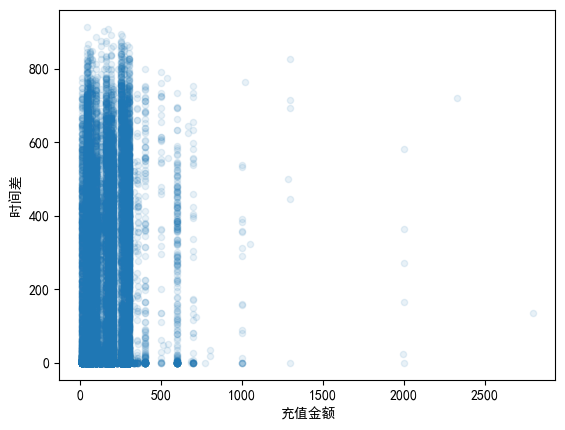

In [38]:
df.plot(kind='scatter',x='充值金额',y='时间差',alpha=0.1)    # 新手上路，kind=图表类型

In [20]:
corr_matrix = df.corr(method='pearson')    # 默认皮尔逊相关系数，非正态数值型用spearman,分类数据用kendall
corr_matrix.sort_values(by='充值金额',axis=0,ascending=False)    # 可以按目标属性降序

C:\Users\HCKJ\AppData\Local\Temp\ipykernel_1244\1228732076.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method='pearson')    # 默认皮尔逊相关系数，非正态数值型用spearman,分类数据用kendall


,UID,充值金额,时间差,时期内充值次数
充值金额,-0.131126,1.000000,0.157031,-0.048177
时间差,-0.857613,0.157031,1.000000,0.190786
时期内充值次数,-0.061326,-0.048177,0.190786,1.000000
UID,1.000000,-0.131126,-0.857613,-0.061326


In [21]:
from pandas .plotting import scatter_matrix    # 相关系数可视化，并绘制数据分布图

In [ ]:
attributes = ['充值金额','时间差']    # 选几列

array([[<AxesSubplot: xlabel='UID', ylabel='UID'>,
        <AxesSubplot: xlabel='充值金额', ylabel='UID'>,
        <AxesSubplot: xlabel='时间差', ylabel='UID'>,
        <AxesSubplot: xlabel='时期内充值次数', ylabel='UID'>],
       [<AxesSubplot: xlabel='UID', ylabel='充值金额'>,
        <AxesSubplot: xlabel='充值金额', ylabel='充值金额'>,
        <AxesSubplot: xlabel='时间差', ylabel='充值金额'>,
        <AxesSubplot: xlabel='时期内充值次数', ylabel='充值金额'>],
       [<AxesSubplot: xlabel='UID', ylabel='时间差'>,
        <AxesSubplot: xlabel='充值金额', ylabel='时间差'>,
        <AxesSubplot: xlabel='时间差', ylabel='时间差'>,
        <AxesSubplot: xlabel='时期内充值次数', ylabel='时间差'>],
       [<AxesSubplot: xlabel='UID', ylabel='时期内充值次数'>,
        <AxesSubplot: xlabel='充值金额', ylabel='时期内充值次数'>,
        <AxesSubplot: xlabel='时间差', ylabel='时期内充值次数'>,
        <AxesSubplot: xlabel='时期内充值次数', ylabel='时期内充值次数'>]], dtype=object)

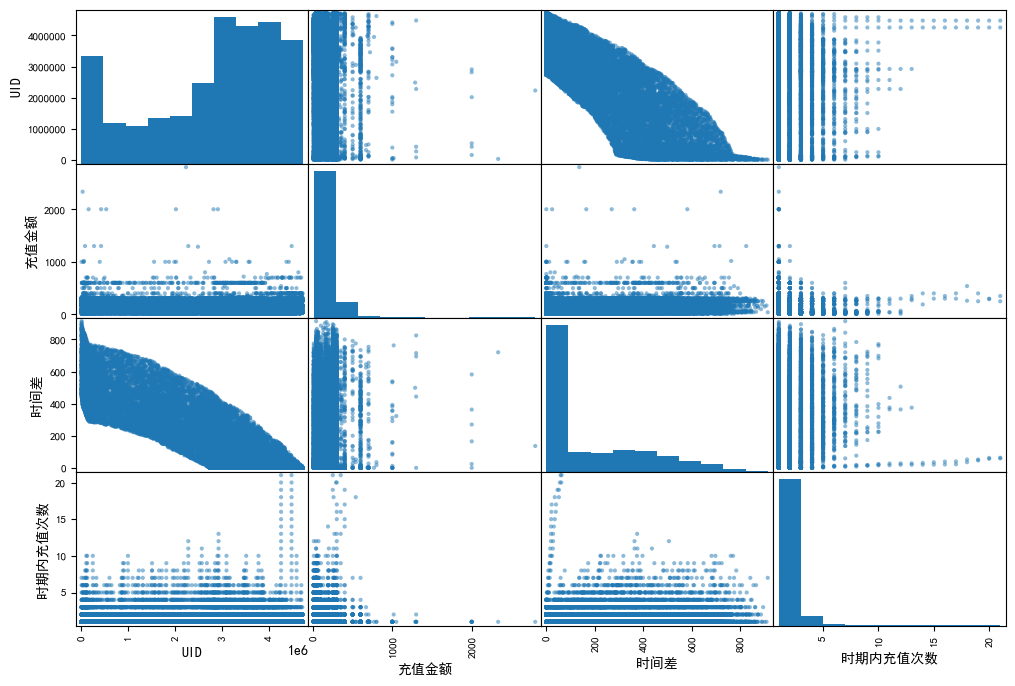

In [22]:
scatter_matrix(df,figsize=(12,8))    # scatter_matrix可以可视化所有列，但是不方便阅读

# 数据分析

In [40]:
df.head()

,UID,注册时间,充值时间,VIP类型,充值金额,充值方式,充值来源,时间差,时期内充值次数,时间桶
25,4691419,2023-04-11 22:56:37,2023-04-25 23:01:39,模板个人VIP 3个月,59.0,微信-威富通,编辑页充值,14,1.0,30日内
26,2464983,2021-11-20 13:58:11,2023-04-25 21:42:48,线上用途SVIP,269.0,微信-威富通,编辑页充值,521,3.0,超过365日
27,855419,2021-04-29 10:48:56,2023-04-25 21:36:46,模板个人VIP 1个月,39.0,微信-威富通,编辑页充值,726,2.0,超过365日
28,4717699,2023-04-25 20:03:17,2023-04-25 20:45:17,模板个人VIP 1个月,39.0,微信-威富通,编辑页充值,0,1.0,当日
29,4717738,2023-04-25 20:26:17,2023-04-25 20:32:31,模板个人VIP 1个月,39.0,微信-威富通,LeftTool,0,1.0,当日


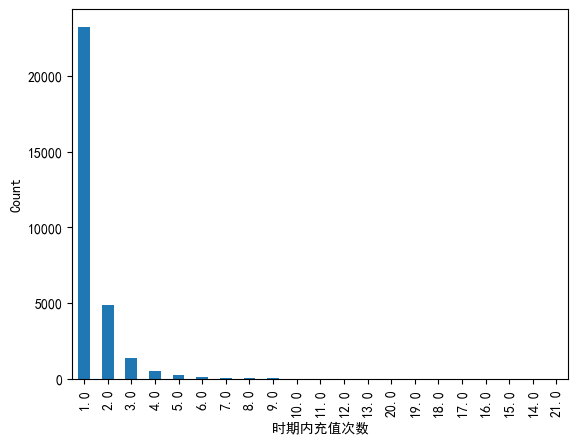

In [41]:
# 统计不同字符串类型的出现次数
counts = df['时期内充值次数'].value_counts()

# 绘制条形图
counts.plot(kind='bar')
plt.xlabel('时期内充值次数')
plt.ylabel('Count')
plt.show()

In [42]:
# 看单独一列内部结构
df['时期内充值次数'].value_counts()

1.0     23231
2.0      4847
3.0      1349
4.0       510
5.0       242
6.0       125
7.0        63
8.0        39
9.0        22
10.0       14
11.0        5
12.0        4
13.0        3
20.0        2
19.0        2
18.0        2
17.0        2
16.0        2
15.0        2
14.0        2
21.0        2
Name: 时期内充值次数, dtype: int64

时期内充值次数 ≥ 2 的用户占比23.76%

# 导出csv

In [47]:
df.to_csv('D:\Ori\数据处理\充值分析\充值数据.csv')